In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from osgeo import gdal
import glob
import pandas as pd
import geopandas as gpd
import numpy as np
from osgeo import ogr
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_selector as selector
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
import pyspatialml as pml
import rasterio as rio
from pyspatialml import Raster
from rasterio import features
from rasterio.mask import mask
import matplotlib as mpl
from tempfile import NamedTemporaryFile
from pyspatialml.preprocessing import xy_coordinates, distance_to_corners
from skopt import BayesSearchCV

In [2]:
dataset = pd.read_csv("C:/Users/Danny/Desktop/EMMA/IV/Data/randomforest/slope_unit/Mappe3.csv", sep = ";")
# Slice the columns from the second item to the end and convert to list
targets = dataset.columns[1:11].tolist()

'''g = sns.pairplot(dataset, hue='geology')
g.fig.suptitle("Scatterplot and histogram of pairs of variables color coded by risk level", 
               fontsize = 14, # defining the size of the title
               y=1.05); # y = definig title y position (height)'''

# %%

# compute VIF for the features
def calculate_vif(df, features):
    vif, tolerance = {}, {}
    
    for feature in features:        
        # extract all the other features you will regress against
        X = [f for f in features if f != feature]
        X, y = df[X], df[feature]
        
        # extract r-squared from the fit
        r2 = LinearRegression().fit(X, y).score(X, y)

        # compute VIF
        vif[feature] = 1 / (1 - r2)
    # return VIF DataFrame
    return pd.DataFrame({'VIF': vif})

# call fuction calculate_vif with features as input
pd.options.display.float_format = '{:.2f}'.format
calculate_vif(df=dataset, 
              features=dataset.columns[dataset.columns != "IDI"].to_list())

,VIF
annual_prec,1.31
aspect,1.06
distance_river,1.53
elevation,6.24
geology,1.10
lulc,3.10
ndvi,5.77
plan_curv,1.89
profile_curv,2.68
slope,3.12


In [3]:
# Bin aspect values into categories
dataset['aspect'] = pd.cut(dataset['aspect'], bins=[22.5, 67.5, 112.5, 157.5, 202.5, 247.5, 292.5, 337.5], labels=["NE", "E", "SE", "S", "SW", "W", "NW"])
dataset['aspect'] = dataset['aspect'].cat.add_categories("N")
dataset['aspect'].fillna("N", inplace=True)
dataset['lulc'] = dataset['lulc'] / 10
dataset['lulc'] = dataset['lulc'].astype(int)

transformer = make_column_transformer(
    (OneHotEncoder(), ['aspect']),
    (OneHotEncoder(), ['lulc']),
    (OneHotEncoder(), ['geology']),
    (OneHotEncoder(), ['soil_parent']),
    remainder='passthrough')

transformed = transformer.fit_transform(dataset)
transformed_df = pd.DataFrame(
    transformed, 
    columns=transformer.get_feature_names_out()
)
cols_to_drop = ['aspect', 'lulc', 'geology', 'soil_parent']
dataset.drop(cols_to_drop, axis=1, inplace=True)
# standardize the dataframe
# define standard scaler

idi = dataset[['IDI']]
dataset_without_idi = dataset.drop(columns=['IDI'])

scaler = StandardScaler()
# transform data
df = scaler.fit_transform(dataset_without_idi)
ds = pd.DataFrame(df, columns=dataset_without_idi.columns)

dataset = pd.concat([ds, transformed_df], axis=1)
cols_to_drop = [col for col in dataset.columns if 'remainder__' in col]
dataset.drop(cols_to_drop, axis=1, inplace=True)
dataset.rename(columns=lambda x: x.split("__")[-1], inplace=True)
# concatenate dataset and idi
dataset = pd.concat([idi, dataset], axis=1)

In [4]:
y = dataset['IDI']
X = dataset.drop(['IDI'], axis=1)

SEED = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=SEED)

features = X.columns.values # The name of each column
classes = ['0', '1'] # The name of each class

In [32]:
# Show individual trees
'''for estimator in rfc.estimators_:
    print(estimator)
    plt.figure(figsize=(12,6))
    tree.plot_tree(estimator,
                   feature_names=features,
                   class_names=classes,
                   fontsize=8, 
                   filled=True, 
                   rounded=True)
    plt.show()'''

'for estimator in rfc.estimators_:\n    print(estimator)\n    plt.figure(figsize=(12,6))\n    tree.plot_tree(estimator,\n                   feature_names=features,\n                   class_names=classes,\n                   fontsize=8, \n                   filled=True, \n                   rounded=True)\n    plt.show()'

OOB score: 0.8683901292596945
              precision    recall  f1-score   support

           0       0.90      0.86      0.88       104
           1       0.87      0.91      0.89       109

    accuracy                           0.88       213
   macro avg       0.88      0.88      0.88       213
weighted avg       0.88      0.88      0.88       213



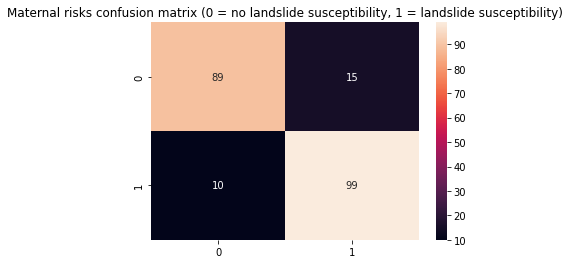

In [9]:
# %%
rfc = RandomForestClassifier(max_features=None, 
                             oob_score=True,
                             random_state=SEED)

rfc.fit(X_train, y_train)
print("OOB score:", rfc.oob_score_)
y_pred = rfc.predict(X_test)
y_proba = rfc.predict_proba(X_test)

print(classification_report(y_test,y_pred))
f1_score_ = f1_score(y_test, y_pred, average='weighted')
f1_score_

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d').set_title('Maternal risks confusion matrix (0 = no landslide susceptibility, 1 = landslide susceptibility)')

'''importances = rfc.feature_importances_
for feature_name, feature_importance in zip(X.columns, importances):
print(feature_name, feature_importance)'''

# Get feature importances
importances = rfc.feature_importances_

NameError: name 'permutation_importance' is not defined

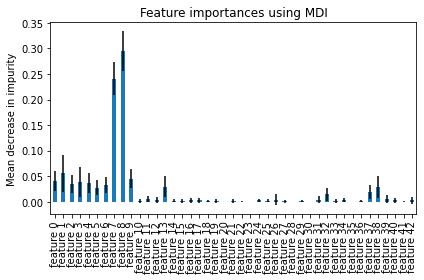

In [17]:
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)

feature_names = [f"feature {i}" for i in range(X.shape[1])]
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()



result = permutation_importance(
    rfc, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
forest_importances = pd.Series(result.importances_mean, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()


In [6]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_extraction.text import CountVectorizer

X_vec = rfc.fit_transform(X)

res = dict(zip(rfc.get_feature_names(),
               mutual_info_classif(X_vec, Y, discrete_features=True)
               ))
print(res)

AttributeError: 'RandomForestClassifier' object has no attribute 'fit_transform'

In [7]:
# Calculate the mutual information scores for each feature
mi_scores = mutual_info_classif(X, y_pred)

# Sort the mutual information scores in descending order
sorted_mi_scores = sorted(zip(X.columns, mi_scores), key=lambda x: x[1], reverse=True)

# Print the ranked list of features
for feature, score in sorted_mi_scores:
    print(f"{feature}: {score:.4f}")

ValueError: Found input variables with inconsistent numbers of samples: [1064, 213]

In [8]:
pipeline = Pipeline([('prep',transformer),
                     ('rfc', rfc)])
pipeline['rfc'].feature_importances_

feat_list = []

total_importance = 0
# Print the name and gini importance of each feature
for feature in zip(targets, pipeline['rfc'].feature_importances_):
    feat_list.append(feature)
    total_importance += feature[1]

included_feats = []
# Print the name and gini importance of each feature
for feature in zip(targets, pipeline['rfc'].feature_importances_):
    if feature[1] > .0:
        included_feats.append(feature[0])

print('\n',"Cumulative Importance =", total_importance)

# create DataFrame using data
df_imp = pd.DataFrame(feat_list, columns =['FEATURE', 'IMPORTANCE']).sort_values(by='IMPORTANCE', ascending=False)
df_imp['CUMSUM'] = df_imp['IMPORTANCE'].cumsum()
df_imp


 Cumulative Importance = 0.8502789450289057


,FEATURE,IMPORTANCE,CUMSUM
8,annual_prec,0.30,0.30
7,ndvi,0.24,0.54
1,slope,0.06,0.59
9,distance_river,0.05,0.64
0,elevation,0.04,0.68
3,total_curv,0.04,0.72
4,profile_curv,0.04,0.75
2,tpi,0.04,0.79
6,vrm,0.03,0.82
5,plan_curv,0.03,0.85


In [54]:
targets = X.columns

# Create a pipeline with a transformer and a random forest classifier
pipeline = Pipeline([('prep', transformer), ('rfc', RandomForestClassifier(n_estimators=100, random_state=1))])

# Fit the pipeline on the data
pipeline.fit(X, y)

'''# Calculate the mutual information score of each feature
mi_scores = mutual_info_classif(pipeline['prep'].transform(X), y)

# Print the feature ranking
feat_list = []
total_mi = 0
for feature in zip(targets, mi_scores):
    feat_list.append(feature)
    total_mi += feature[1]

included_feats = []
for feature in zip(targets, mi_scores):
    if feature[1] > 0:
        included_feats.append(feature[0])

print('\n', "Cumulative Mutual Information =", total_mi)

df_mi = pd.DataFrame(feat_list, columns=['FEATURE', 'MUTUAL_INFORMATION']).sort_values(by='MUTUAL_INFORMATION', ascending=False)
df_mi['CUMSUM'] = df_mi['MUTUAL_INFORMATION'].cumsum()
df_mi'''

ValueError: A given column is not a column of the dataframe

In [24]:
from sklearn.feature_selection import mutual_info_classif

# Calculate the information gain of each feature
scores = mutual_info_classif(X, y, discrete_features='auto', n_neighbors=3, copy=True, random_state=None)

# Print the feature ranking
print("Feature ranking:")
for i in range(X.shape[1]):
    print("%d. %s (%f)" % (i + 1, X.columns[i], scores[i]))

Feature ranking:
1. elevation (0.107564)
2. slope (0.075058)
3. tpi (0.034246)
4. total_curv (0.079258)
5. profile_curv (0.009393)
6. plan_curv (0.026436)
7. vrm (0.035213)
8. ndvi (0.131315)
9. annual_prec (0.225109)
10. distance_river (0.000000)
11. aspect_E (0.000031)
12. aspect_N (0.000000)
13. aspect_NE (0.000000)
14. aspect_NW (0.021909)
15. aspect_S (0.000000)
16. aspect_SE (0.011003)
17. aspect_SW (0.000000)
18. aspect_W (0.014987)
19. lulc_1 (0.000000)
20. lulc_3 (0.012656)
21. lulc_4 (0.003345)
22. lulc_6 (0.000000)
23. lulc_7 (0.084514)
24. lulc_8 (0.009949)
25. lulc_10 (0.000000)
26. geology_10 (0.021017)
27. geology_11 (0.013571)
28. geology_12 (0.000000)
29. geology_13 (0.000000)
30. geology_15 (0.000000)
31. geology_16 (0.004161)
32. geology_24 (0.030801)
33. geology_26 (0.069489)
34. geology_27 (0.006488)
35. geology_30 (0.000000)
36. soil_parent_0 (0.005669)
37. soil_parent_9 (0.012707)
38. soil_parent_11 (0.014702)
39. soil_parent_12 (0.015299)
40. soil_parent_14 (0.0

In [200]:
# evaluate the model using test set
results = permutation_importance(rfc, X_test, y_test, scoring='accuracy', n_repeats=10, random_state=0)

# summarize the feature importance scores
for i in results.importances_mean.argsort()[::-1]:
    print(f"{X_test.columns[i]:<20} "
          f"{results.importances_mean[i]:.3f}"
          f" +/- {results.importances_std[i]:.3f}")

annual_prec          0.169 +/- 0.023
ndvi                 0.121 +/- 0.017
soil_parent_12       0.045 +/- 0.005
slope                0.041 +/- 0.011
elevation            0.035 +/- 0.006
soil_parent_11       0.023 +/- 0.004
aspect_NW            0.014 +/- 0.004
total_curv           0.012 +/- 0.005
distance_river       0.008 +/- 0.005
tpi                  0.008 +/- 0.005
plan_curv            0.008 +/- 0.004
vrm                  0.007 +/- 0.005
lulc_10              0.006 +/- 0.000
geology_26           0.005 +/- 0.004
geology_24           0.005 +/- 0.003
aspect_SW            0.003 +/- 0.001
lulc_6               0.002 +/- 0.001
geology_10           0.001 +/- 0.002
aspect_SE            0.001 +/- 0.002
profile_curv         0.001 +/- 0.005
soil_parent_14       0.001 +/- 0.001
lulc_3               0.001 +/- 0.001
geology_15           0.001 +/- 0.001
aspect_NE            0.001 +/- 0.001
lulc_7               0.001 +/- 0.001
geology_27           0.000 +/- 0.001
geology_12           0.000 +/- 0.001
a

In [148]:
# Define the hyperparameter search space
search_spaces = {
    'n_estimators': (10, 1000, 100),
    'max_depth': (1, 30, 2),
    'min_samples_split': (2, 20),
    'min_samples_leaf': (1, 10),
    'max_features': ("sqrt", "log2", None),
}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use BayesSearchCV for hyperparameter optimization
opt = BayesSearchCV(rf, search_spaces, n_iter=50, cv=5)

# Fit the optimization model to the training data
opt.fit(X_train, y_train)

# Print the best hyperparameters found
print("Best hyperparameters: ", opt.best_params_)

# Evaluate the optimized model on the test data
accuracy = opt.score(X_test, y_test)
print("Test accuracy: ", accuracy)

AttributeError: module 'numpy' has no attribute 'int'.
`np.int` was a deprecated alias for the builtin `int`. To avoid this error in existing code, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [15]:
df_without_IDI = dataset[[col for col in dataset.columns if col != "IDI"]]
feature_imp = pd.Series(rfc_.feature_importances_,index=df_without_IDI.columns).sort_values(ascending=False)
feature_imp


# %%
param_grid = {
    'bootstrap': [True],
    'max_depth': [None, 5, 10, 20, 50, 80, 90, 100, 110],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000],
    'n_estimators': [25, 50, 100, 150],
    'max_leaf_nodes': [None, 3, 6, 9],
}

# %%
model_grid = RandomForestClassifier(max_features=None,
                                    n_estimators=150)
model_grid.fit(X_train, y_train)
y_pred_grid = model_grid.predict(X_test)
print(classification_report(y_pred_grid, y_test))

grid_search = GridSearchCV(RandomForestClassifier(),
                           param_grid=param_grid)
grid_search.fit(X_train, y_train)
print(grid_search.best_estimator_)

KeyboardInterrupt: 

In [38]:
random_search = RandomizedSearchCV(RandomForestClassifier(),
                                   param_grid)
random_search.fit(X_train, y_train)
print(random_search.best_estimator_)

RandomForestClassifier(max_depth=110, max_features=None, min_samples_leaf=3,
                       min_samples_split=12, n_estimators=50)


In [40]:
model_random = RandomForestClassifier(max_depth=110, 
                                      max_features=None, 
                                      min_samples_leaf=3, 
                                      min_samples_split=12, 
                                      n_estimators=50)
model_random.fit(X_train, y_train)
y_pred_rand = model_random.predict(X_test)
print(classification_report(y_pred_rand, y_test))

              precision    recall  f1-score   support

           0       0.81      0.91      0.86       148
           1       0.91      0.82      0.86       172

    accuracy                           0.86       320
   macro avg       0.86      0.86      0.86       320
weighted avg       0.86      0.86      0.86       320



In [45]:
# Convert importances and std to pandas DataFrames
importances = pd.DataFrame(rfc_.feature_importances_, index=rfc_.feature_names_in_, columns=['importance'])
std = pd.DataFrame(std, index=rfc_.feature_names_in_, columns=['std'])

# Group the one-hot encoded predictors back to their original feature
grouped_importances = importances.groupby(lambda x: x.split('_')[0], axis=0).mean()
grouped_std = std.groupby(lambda x: x.split('_')[0], axis=0).mean()

# Plot the grouped feature importances
fig, ax = plt.subplots()
grouped_importances.plot.bar(yerr=grouped_std['std'], ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

# Sort the grouped feature importances in descending order
grouped_importances.sort_values(by='importance', ascending=False, inplace=True)

# Print the ranked feature importances and standard deviations
for feature, importance, std_dev in zip(grouped_importances.index, grouped_importances['importance'], grouped_std['std']):
    print(f"Feature: {feature}")
    print(f"Importance: {importance:.3f}")
    print(f"Standard Deviation: {std_dev:.3f}\n")

NameError: name 'std' is not defined

In [ ]:
import imblearn

def compute_feature_importance(model):
    """
    Create feature importance using sklearn's ensemble models model.feature_importances_ property.
    
    Parameters
    ----------
    model : estimator instance (either sklearn.Pipeline, imblearn.Pipeline or a classifier)
        PRE-FITTED classifier or a PRE-FITTED Pipeline in which the last estimator is a classifier.

    Returns
    -------
    fi_df : Pandas DataFrame with feature_names and feature_importance
    """
    
    if type(model) == imblearn.pipeline.Pipeline:
        # If the user is using a pipeline model, 
        # the importance of the feature is calculated in this if block!
        pre_model = model['pre'] # Pre step of the pipeline
        classifier = model['clf'] # Classifier of the pipeline
        ct = model.named_steps['pre'] # Define the column transform for the given pipeline model 
        # The following line will get the feature names.
        feature_names = pre_model.get_feature_names_out()
        feature_importance = np.array(classifier.feature_importances_)
        # Create a DataFrame using a Dictionary
        data = {'feature_names': feature_names, 'feature_importance': feature_importance}
        fi_df = pd.DataFrame(data)
        # Sort the DataFrame in order decreasing feature importance
        fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)
        
        if 'cat' in ct.named_transformers_.keys() and hasattr(ct.named_transformers_['cat'], 'feature_names_in_'):

            # We first have to apply a column transform and then sum up the feature importance values of individual OneHotEncoder columns.
            # Original categorical features list. Categorical features before applying OneHotEncoder
            original_cat_features = ct.named_transformers_['cat'].feature_names_in_.tolist()
            
            # Categorical features list after applying OneHotEncoder
            all_cat_list = ct.named_transformers_['cat'].get_feature_names_out(original_cat_features).tolist()
            
            # A for loop for original_cat_features to find the one hot encoded features corresponding to each original categorical feature   
            for original_cat_feature in original_cat_features:
                # List of one hot encoded features corresponding to each original categorical feature
                cat_list = [i for i in all_cat_list if i.startswith(original_cat_feature)]
                # OneHotEncoded columns must be renamed.
                # ct.named transformers['cat'].get_feature_names_out(original cat_features) returns column names missing "cat__" in front.
                # Let's fix it easily!
                for i, element in enumerate(cat_list):
                    cat_list[i] = 'cat__' + element
                # Slice fi_df dataframe to return the only rows for the associated OneHotEncoded features names (cat_list) 
                # and then sum the feature importance values
                cat_sum = fi_df[fi_df['feature_names'].isin(cat_list)]['feature_importance'].sum()
                # Slice fi_df dataframe to return the only rows other than categorical features.
                # In other words, dataframe with numerical features
                fi_df = fi_df[~fi_df['feature_names'].isin(cat_list)]
                # Create a temporary dictionary to return the originial categorical feature 
                # and the summation of OneHotEncoded features importances
                temp_dict = {'feature_names': original_cat_feature, 'feature_importance': cat_sum}
                # Append the temporary_dict to the dataframe
                fi_df = fi_df.append(temp_dict, ignore_index=True)
            # Sort the DataFrame in order decreasing feature importance
            fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)
            
        # Getting rid of the prefixes of the feature names    
        prefixes = ('num__', 'cat__', 'remainder__', 'scaler__')
        for prefix in prefixes:
            fi_df['feature_names'] = fi_df['feature_names'].apply(lambda x: str(x).replace(prefix,""))
            
    return fi_df

In [ ]:
from sklearn.metrics import accuracy_score
threshold = 0.50

predicted_proba = rfc_.predict_proba(X_test)
predicted = (predicted_proba [:,1] >= threshold).astype('int')

accuracy = accuracy_score(y_test, predicted)
accuracy


# %%
score = roc_auc_score(y_test, y_pred)
print(f"ROC AUC: {score:.4f}")

score = roc_auc_score(y_test, y_proba[:, 1])
print(f"ROC AUC: {score:.4f}")

In [ ]:
def plot_sklearn_roc_curve(y_test, y_pred):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    roc_display.figure_.set_size_inches(5,5)
    plt.plot([0, 1], [0, 1], color = 'g')# Plots the ROC curve using the sklearn methods - Good plot
plot_sklearn_roc_curve(y_test, y_proba[:, 1])# Plots the ROC curve using the sklearn methods - Bad plot
plot_sklearn_roc_curve(y_test, y_pred)

In [ ]:
rasin = "C:/Users/Danny/Desktop/EMMA/IV/Data/randomforest/slope_unit/geo-environmental/bound.tif"
shpin = "C:/Users/Danny/Desktop/EMMA/IV/Data/randomforest/slope_unit/bbox-1.shp"
bboxFile = "C:/Users/Danny/Desktop/EMMA/IV/Data/randomforest/slope_unit/geo-environmental/bound1.tif"
shp = ogr.Open(shpin)
lyr = shp.GetLayer()
sr = lyr.GetSpatialRef()

result = gdal.Warp(bboxFile, rasin, cutlineDSName=shpin)

bbox = gdal.Open(bboxFile, 0)  # this opens the file in only reading mode
bboxTrans = bbox.GetGeoTransform()
x_res = bboxTrans[1]
y_res = -bboxTrans[5]  # make sure this value is positive
kwargs = {"format": "GTiff", "xRes": x_res, "yRes": y_res}

In [ ]:
elevation_inputFile = gdal.Open("C:/Users/Danny/Desktop/EMMA/IV/Data/randomforest/slope_unit/geo-environmental/DEM_filled.tif")
elevation_outputFile = "C:/Users/Danny/Desktop/EMMA/IV/Data/randomforest/slope_unit/raster/01_elevation.tif"
dst_ds = gdal.Warp(elevation_outputFile, elevation_inputFile, dstSRS=sr, **kwargs, cutlineDSName=shpin)

slope_inputFile = gdal.Open("C:/Users/Danny/Desktop/EMMA/IV/Data/randomforest/slope_unit/geo-environmental/slope.tif")
slope_outputFile = "C:/Users/Danny/Desktop/EMMA/IV/Data/randomforest/slope_unit/raster/02_slope.tif"
ds = gdal.Warp(slope_outputFile, slope_inputFile, dstSRS=sr, **kwargs, cutlineDSName=shpin)

roughness_inputFile = gdal.Open("C:/Users/Danny/Desktop/EMMA/IV/Data/randomforest/slope_unit/geo-environmental/roughness.tif")
roughness_outputFile = "C:/Users/Danny/Desktop/EMMA/IV/Data/randomforest/slope_unit/raster/03_roughness.tif"
ds = gdal.Warp(roughness_outputFile, roughness_inputFile, dstSRS=sr, **kwargs, cutlineDSName=shpin)

tpi_inputFile = gdal.Open("C:/Users/Danny/Desktop/EMMA/IV/Data/randomforest/slope_unit/geo-environmental/tri.tif")
tpi_outputFile = "C:/Users/Danny/Desktop/EMMA/IV/Data/randomforest/slope_unit/raster/04_tri.tif"
ds = gdal.Warp(tpi_outputFile, tpi_inputFile, dstSRS=sr, **kwargs, cutlineDSName=shpin)

tpi_inputFile = gdal.Open("C:/Users/Danny/Desktop/EMMA/IV/Data/randomforest/slope_unit/geo-environmental/tpi.tif")
tpi_outputFile = "C:/Users/Danny/Desktop/EMMA/IV/Data/randomforest/slope_unit/raster/05_tpi.tif"
ds = gdal.Warp(tpi_outputFile, tpi_inputFile, dstSRS=sr, **kwargs, cutlineDSName=shpin)

total_curv_inputFile = gdal.Open("C:/Users/Danny/Desktop/EMMA/IV/Data/randomforest/slope_unit/geo-environmental/total_curv.sdat")
total_curv_outputFile = "C:/Users/Danny/Desktop/EMMA/IV/Data/randomforest/slope_unit/raster/06_total_curv.tif"
ds = gdal.Warp(total_curv_outputFile, total_curv_inputFile, dstSRS=sr, **kwargs, cutlineDSName=shpin)

profile_curv_inputFile = gdal.Open("C:/Users/Danny/Desktop/EMMA/IV/Data/randomforest/slope_unit/geo-environmental/profile_curv.sdat")
profile_curv_outputFile = "C:/Users/Danny/Desktop/EMMA/IV/Data/randomforest/slope_unit/raster/07_profile_curv.tif"
ds = gdal.Warp(profile_curv_outputFile, profile_curv_inputFile, dstSRS=sr, **kwargs, cutlineDSName=shpin)

plan_curv_inputFile = gdal.Open("C:/Users/Danny/Desktop/EMMA/IV/Data/randomforest/slope_unit/geo-environmental/plan_curv.sdat")
plan_curv_outputFile = "C:/Users/Danny/Desktop/EMMA/IV/Data/randomforest/slope_unit/raster/08_plan_curv.tif"
ds = gdal.Warp(plan_curv_outputFile, plan_curv_inputFile, dstSRS=sr, **kwargs, cutlineDSName=shpin)

min_curv_inputFile = gdal.Open("C:/Users/Danny/Desktop/EMMA/IV/Data/randomforest/slope_unit/geo-environmental/min_curv.sdat")
min_curv_outputFile = "C:/Users/Danny/Desktop/EMMA/IV/Data/randomforest/slope_unit/raster/09_min_curv.tif"
ds = gdal.Warp(min_curv_outputFile, min_curv_inputFile, dstSRS=sr, **kwargs, cutlineDSName=shpin)

max_curv_inputFile = gdal.Open("C:/Users/Danny/Desktop/EMMA/IV/Data/randomforest/slope_unit/geo-environmental/max_curv.sdat")
max_curv_outputFile = "C:/Users/Danny/Desktop/EMMA/IV/Data/randomforest/slope_unit/raster/10_max_curv.tif"
ds = gdal.Warp(max_curv_outputFile, max_curv_inputFile, dstSRS=sr, **kwargs, cutlineDSName=shpin)

general_curv_inputFile = gdal.Open("C:/Users/Danny/Desktop/EMMA/IV/Data/randomforest/slope_unit/geo-environmental/General_curv.sdat")
general_curv_outputFile = "C:/Users/Danny/Desktop/EMMA/IV/Data/randomforest/slope_unit/raster/11_general_curv.tif"
ds = gdal.Warp(general_curv_outputFile, general_curv_inputFile, dstSRS=sr, **kwargs, cutlineDSName=shpin)

vrm_inputFile = gdal.Open("C:/Users/Danny/Desktop/EMMA/IV/Data/randomforest/slope_unit/geo-environmental/vrm.sdat")
vrm_outputFile = "C:/Users/Danny/Desktop/EMMA/IV/Data/randomforest/slope_unit/raster/12_vrm.tif"
ds = gdal.Warp(vrm_outputFile, vrm_inputFile, dstSRS=sr, **kwargs, cutlineDSName=shpin)

ndvi_inputFile = gdal.Open("C:/Users/Danny/Desktop/EMMA/IV/Data/randomforest/slope_unit/geo-environmental/ndvi.tif")
ndvi_outputFile = "C:/Users/Danny/Desktop/EMMA/IV/Data/randomforest/slope_unit/raster/13_ndvi.tif"
ds = gdal.Warp(ndvi_outputFile, ndvi_inputFile, dstSRS=sr, **kwargs, cutlineDSName=shpin)


annual_prec_inputFile = gdal.Open("C:/Users/Danny/Desktop/EMMA/IV/Data/randomforest/slope_unit/geo-environmental/annual_precipitation.tif")
annual_prec_outputFile = "C:/Users/Danny/Desktop/EMMA/IV/Data/randomforest/slope_unit/raster/14_annual_prec.tif"
ds = gdal.Warp(annual_prec_outputFile, annual_prec_inputFile, dstSRS=sr, **kwargs, cutlineDSName=shpin)

distance_to_river_inputFile = gdal.Open("C:/Users/Danny/Desktop/EMMA/IV/Data/randomforest/slope_unit/geo-environmental/channel_proximity.tif")
distance_to_river_outputFile = "C:/Users/Danny/Desktop/EMMA/IV/Data/randomforest/slope_unit/raster/15_distance_river.tif"
ds = gdal.Warp(distance_to_river_outputFile, distance_to_river_inputFile, dstSRS=sr, **kwargs, cutlineDSName=shpin)

aspect_inputFile = gdal.Open("C:/Users/Danny/Desktop/EMMA/IV/Data/randomforest/slope_unit/geo-environmental/aspect.tif")
aspect_outputFile = "C:/Users/Danny/Desktop/EMMA/IV/Data/randomforest/slope_unit/geo-environmental/aspect_bound.tif"
ds = gdal.Warp(aspect_outputFile, aspect_inputFile, dstSRS=sr, **kwargs, cutlineDSName=shpin)

aspect = gdal.Open("C:/Users/Danny/Desktop/EMMA/IV/Data/randomforest/slope_unit/geo-environmental/aspect_bound.tif")
raster = aspect.ReadAsArray()

raster[(raster < 0)] = 0
raster[(raster >= 0) & (raster < 22.5)] = 1
raster[(raster > 22.5) & (raster < 67.5)] = 2
raster[(raster > 67.5) & (raster < 112.5)] = 3
raster[(raster > 112.5) & (raster < 157.5)] = 4
raster[(raster > 157.5) & (raster < 202.5)] = 5
raster[(raster > 202.5) & (raster < 247.5)] = 6
raster[(raster > 247.5) & (raster < 292.5)] = 7
raster[(raster > 292.5) & (raster < 337.5)] = 8
raster[(raster > 292.5)] = 9

mapping = {0: "NaN", 1: "N", 2: "NE", 3: "E", 4: "SE", 5: "S", 6: "SW", 7: "W", 8: "NW", 9: "N"}
raster = np.array([mapping[x] for x in raster.flatten()]).reshape(raster.shape)

# Convert the raster data into class labels
classes = np.unique(raster)
labels = np.zeros_like(raster)
for i, c in enumerate(classes):
    labels[raster==c] = i+1

# One-hot encode the class labels
onehot_encoder = OneHotEncoder(categories='auto')
labels = labels.reshape(labels.shape[0]*labels.shape[1], 1)
onehot = onehot_encoder.fit_transform(labels).toarray()

# Check the results
# Create a new raster file
driver = gdal.GetDriverByName("GTiff")
out_raster = driver.Create("C:/Users/Danny/Desktop/EMMA/IV/Data/randomforest/slope_unit/raster/16_aspect_encoded.tif", aspect.RasterXSize, aspect.RasterYSize, onehot.shape[1], gdal.GDT_Byte)
out_raster.SetGeoTransform(aspect.GetGeoTransform())
out_raster.SetProjection(aspect.GetProjection())

# Write the one-hot encoded data to the new raster file
for i in range(onehot.shape[1]):
    band = out_raster.GetRasterBand(i+1)
    band.WriteArray(onehot[:,i].reshape(raster.shape))

# Close the raster file
out_raster = None


landcover_inputFile = gdal.Open("C:/Users/Danny/Desktop/EMMA/IV/Data/randomforest\slope_unit/geo-environmental/landcover1.tif")
landcover_outputFile = "C:/Users/Danny/Desktop/EMMA/IV/Data/randomforest/slope_unit/geo-environmental/landcover1_bound.tif"
ds = gdal.Warp(landcover_outputFile, landcover_inputFile, dstSRS=sr, **kwargs, cutlineDSName=shpin)

lulc = gdal.Open("C:/Users/Danny/Desktop/EMMA/IV/Data/randomforest/slope_unit/geo-environmental/landcover1_bound.tif")

# Read the raster data into a numpy array
raster = lulc.ReadAsArray()
raster = raster / 10

# Convert the raster data into class labels
classes = np.unique(raster)
labels = np.zeros_like(raster)
for i, c in enumerate(classes):
    labels[raster==c] = i+1

# One-hot encode the class labels
onehot_encoder = OneHotEncoder(categories='auto')
labels = labels.reshape(labels.shape[0]*labels.shape[1], 1)
onehot = onehot_encoder.fit_transform(labels).toarray()

# Check the results
# Create a new raster file
driver = gdal.GetDriverByName("GTiff")
out_raster = driver.Create("C:/Users/Danny/Desktop/EMMA/IV/Data/randomforest/slope_unit/raster/17_lulc_encoded.tif", lulc.RasterXSize, lulc.RasterYSize, onehot.shape[1], gdal.GDT_Byte)
out_raster.SetGeoTransform(lulc.GetGeoTransform())
out_raster.SetProjection(lulc.GetProjection())

# Write the one-hot encoded data to the new raster file
for i in range(onehot.shape[1]):
    band = out_raster.GetRasterBand(i+1)
    band.WriteArray(onehot[:,i].reshape(raster.shape))

# Close the raster file
out_raster = None


geology_inputFile = gdal.Open("C:/Users/Danny/Desktop/EMMA/IV/Data/randomforest/slope_unit/geo-environmental/geology1.tif")
geology_outputFile = "C:/Users/Danny/Desktop/EMMA/IV/Data/randomforest/slope_unit/geo-environmental/geology_bound.tif"
ds = gdal.Warp(geology_outputFile, geology_inputFile, dstSRS=sr, **kwargs, cutlineDSName=shpin)

geology = gdal.Open("C:/Users/Danny/Desktop/EMMA/IV/Data/randomforest/slope_unit/geo-environmental/geology_bound.tif")
raster = geology.ReadAsArray()

# Convert the raster data into class labels
classes = np.unique(raster)
labels = np.zeros_like(raster)
for i, c in enumerate(classes):
    labels[raster==c] = i+1

# One-hot encode the class labels
onehot_encoder = OneHotEncoder(categories='auto')
labels = labels.reshape(labels.shape[0]*labels.shape[1], 1)
onehot = onehot_encoder.fit_transform(labels).toarray()

# Check the results
# Create a new raster file
driver = gdal.GetDriverByName("GTiff")
out_raster = driver.Create("C:/Users/Danny/Desktop/EMMA/IV/Data/randomforest/slope_unit/raster/18_geology_encoded.tif", geology.RasterXSize, geology.RasterYSize, onehot.shape[1], gdal.GDT_Byte)
out_raster.SetGeoTransform(geology.GetGeoTransform())
out_raster.SetProjection(geology.GetProjection())

# Write the one-hot encoded data to the new raster file
for i in range(onehot.shape[1]):
    band = out_raster.GetRasterBand(i+1)
    band.WriteArray(onehot[:,i].reshape(raster.shape))

# Close the raster file
out_raster = None


soilparent_inputFile = gdal.Open("C:/Users/Danny/Desktop/EMMA/IV/Data/randomforest/slope_unit/geo-environmental/soilparent.tif")
soilparent_outputFile = "C:/Users/Danny/Desktop/EMMA/IV/Data/randomforest/slope_unit/geo-environmental/soilparent_bound.tif"
ds = gdal.Warp(soilparent_outputFile, soilparent_inputFile, dstSRS=sr, **kwargs, cutlineDSName=shpin, resampleAlg = gdal.GRA_Mode)

soil_parent = gdal.Open("C:/Users/Danny/Desktop/EMMA/IV/Data/randomforest/slope_unit/geo-environmental/soilparent_bound.tif")
raster = soilparent_inputFile.ReadAsArray()


# Convert the raster data into class labels
classes = np.unique(raster)
labels = np.zeros_like(raster)
for i, c in enumerate(classes):
    labels[raster==c] = i+1

# One-hot encode the class labels
onehot_encoder = OneHotEncoder(categories='auto')
labels = labels.reshape(labels.shape[0]*labels.shape[1], 1)
onehot = onehot_encoder.fit_transform(labels).toarray()

# Check the results
# Create a new raster file
driver = gdal.GetDriverByName("GTiff")
out_raster = driver.Create("C:/Users/Danny/Desktop/EMMA/IV/Data/randomforest/slope_unit/raster/19_soil_parent_encoded.tif", soil_parent.RasterXSize, soil_parent.RasterYSize, onehot.shape[1], gdal.GDT_Byte)
out_raster.SetGeoTransform(soil_parent.GetGeoTransform())
out_raster.SetProjection(soil_parent.GetProjection())

# Write the one-hot encoded data to the new raster file
for i in range(onehot.shape[1]):
    band = out_raster.GetRasterBand(i+1)
    band.WriteArray(onehot[:,i].reshape(raster.shape))

# Close the raster file
out_raster = None

In [ ]:
elevation_raster = rio.open(r"C:/Users/Danny/Desktop/EMMA/IV/Data/randomforest/slope_unit/raster/01_elevation.tif")
elevation = elevation_raster.read(1, masked=True)

slope_raster = rio.open(r"C:/Users/Danny/Desktop/EMMA/IV/Data/randomforest/slope_unit/raster/02_slope.tif")
slope = slope_raster.read(1, masked=True)
slope_raster = None

roughness_raster = rio.open(r"C:/Users/Danny/Desktop/EMMA/IV/Data/randomforest/slope_unit/raster/03_roughness.tif")
roughness = roughness_raster.read(1, masked=True)
roughness_raster = None

tri_raster = rio.open(r"C:/Users/Danny/Desktop/EMMA/IV/Data/randomforest/slope_unit/raster/04_tri.tif")
tri = tri_raster.read(1, masked=True)
tri_raster = None

tpi_raster = rio.open(r"C:/Users/Danny/Desktop/EMMA/IV/Data/randomforest/slope_unit/raster/05_tpi.tif")
tpi = tpi_raster.read(1, masked=True)
tpi_raster = None

total_curv_raster = rio.open(r"C:/Users/Danny/Desktop/EMMA/IV/Data/randomforest/slope_unit/raster/06_total_curv.tif")
total_curv = total_curv_raster.read(1, masked=True)
total_curv_raster = None

profile_curv_raster = rio.open(r"C:/Users/Danny/Desktop/EMMA/IV/Data/randomforest/slope_unit/raster/07_profile_curv.tif")
profile_curv = profile_curv_raster.read(1, masked=True)
profile_curv_raster = None

plan_curv_raster = rio.open(r"C:/Users/Danny/Desktop/EMMA/IV/Data/randomforest/slope_unit/raster/08_plan_curv.tif")
plan_curv = plan_curv_raster.read(1, masked=True)
plan_curv_raster = None

min_curv_raster = rio.open(r"C:/Users/Danny/Desktop/EMMA/IV/Data/randomforest/slope_unit/raster/09_min_curv.tif")
min_curv = min_curv_raster.read(1, masked=True)
min_curv_raster = None

max_curv_raster = rio.open(r"C:/Users/Danny/Desktop/EMMA/IV/Data/randomforest/slope_unit/raster/10_max_curv.tif")
max_curv = max_curv_raster.read(1, masked=True)
max_curv_raster = None

general_curv_raster = rio.open(r"C:/Users/Danny/Desktop/EMMA/IV/Data/randomforest/slope_unit/raster/11_general_curv.tif")
general_curv = general_curv_raster.read(1, masked=True)
general_curv_raster = None

vrm_raster = rio.open(r"C:/Users/Danny/Desktop/EMMA/IV/Data/randomforest/slope_unit/raster/12_vrm.tif")
vrm = vrm_raster.read(1, masked=True)
vrm_raster = None

ndvi_raster = rio.open(r"C:/Users/Danny/Desktop/EMMA/IV/Data/randomforest/slope_unit/raster/13_ndvi.tif")
ndvi = ndvi_raster.read(1, masked=True)
ndvi_raster = None

annual_prec_raster = rio.open(r"C:/Users/Danny/Desktop/EMMA/IV/Data/randomforest/slope_unit/raster/14_annual_prec.tif")
annual_prec = annual_prec_raster.read(1, masked=True)
annual_prec_raster = None

distance_river_raster = rio.open(r"C:/Users/Danny/Desktop/EMMA/IV/Data/randomforest/slope_unit/raster/15_distance_river.tif")
distance_river = distance_river_raster.read(1, masked=True)
distance_river_raster = None

aspect_raster = rio.open(r'C:/Users/Danny/Desktop/EMMA/IV/Data/randomforest/slope_unit/raster/16_aspect_encoded.tif')
aspect_N = aspect_raster.read(1, masked=True)
aspect_NE = aspect_raster.read(2, masked=True)
aspect_E = aspect_raster.read(3, masked=True)
aspect_SE = aspect_raster.read(4, masked=True)
aspect_S = aspect_raster.read(5, masked=True)
aspect_SW = aspect_raster.read(6, masked=True)
aspect_W = aspect_raster.read(7, masked=True)
aspect_NW = aspect_raster.read(8, masked=True)
aspect_raster = None

landcover_raster = rio.open(r'C:/Users/Danny/Desktop/EMMA/IV/Data/randomforest/slope_unit/raster/17_lulc_encoded.tif')
lulc_1 = landcover_raster.read(2, masked=True)
#lulc_2 = landcover_raster.read(3, masked=True)
lulc_3 = landcover_raster.read(4, masked=True)
lulc_4 = landcover_raster.read(5, masked=True)
#lulc_5 = landcover_raster.read(6, masked=True)
lulc_6 = landcover_raster.read(7, masked=True)
lulc_7 = landcover_raster.read(8, masked=True)
lulc_8 = landcover_raster.read(9, masked=True)
lulc_10 = landcover_raster.read(10, masked=True)
landcover_raster = None

geology_raster = rio.open(r'C:/Users/Danny/Desktop/EMMA/IV/Data/randomforest/slope_unit/raster/18_geology_encoded.tif')
geology_10 = geology_raster.read(2, masked=True)
geology_11 = geology_raster.read(3, masked=True)
geology_12 = geology_raster.read(4, masked=True)
geology_13 = geology_raster.read(5, masked=True)
#geology_14 = geology_raster.read(6, masked=True)
geology_15 = geology_raster.read(7, masked=True)
geology_16 = geology_raster.read(8, masked=True)
#geology_17 = geology_raster.read(9, masked=True)
#geology_18 = geology_raster.read(10, masked=True)
#geology_19 = geology_raster.read(11, masked=True)
#geology_20 = geology_raster.read(12, masked=True)
#geology_21 = geology_raster.read(13, masked=True)
#geology_22 = geology_raster.read(14, masked=True)
#geology_23 = geology_raster.read(15, masked=True)
geology_24 = geology_raster.read(16, masked=True)
#geology_25 = geology_raster.read(17, masked=True)
geology_26 = geology_raster.read(18, masked=True)
geology_27 = geology_raster.read(19, masked=True)
#geology_28 = geology_raster.read(20, masked=True)
#geology_29 = geology_raster.read(21, masked=True)
geology_30 = geology_raster.read(22, masked=True)
geology_raster = None

soilparent_raster = rio.open(r'C:/Users/Danny/Desktop/EMMA/IV/Data/randomforest/slope_unit/raster/19_soil_parent_encoded.tif')
soil_parent_0 = soilparent_raster.read(11, masked=True)
soil_parent_9 = soilparent_raster.read(2, masked=True)
#soil_parent_10 = soilparent_raster.read(3, masked=True)
soil_parent_11 = soilparent_raster.read(4, masked=True)
soil_parent_12 = soilparent_raster.read(5, masked=True)
#soil_parent_13 = soilparent_raster.read(6, masked=True)
soil_parent_14 = soilparent_raster.read(7, masked=True)
soil_parent_15 = soilparent_raster.read(8, masked=True)
soil_parent_16 = soilparent_raster.read(9, masked=True)
soil_parent_17 = soilparent_raster.read(10, masked=True)
soilparent_raster = None

In [ ]:
predictor_files = [elevation, slope, roughness, tri, tpi, total_curv, profile_curv , plan_curv, min_curv, 
                   max_curv, general_curv, vrm, ndvi, annual_prec, distance_river, aspect_N, aspect_NE, aspect_E, 
                   aspect_SE, aspect_S, aspect_SW, aspect_W, aspect_NW, lulc_1, lulc_3, lulc_4, lulc_6, lulc_7, 
                   lulc_8, lulc_10, geology_10, geology_11, geology_12, geology_13, geology_15, geology_16, 
                   geology_24, geology_26, geology_27, geology_30, soil_parent_0, soil_parent_9, soil_parent_11, 
                   soil_parent_12, soil_parent_14, soil_parent_15, soil_parent_16, soil_parent_17]

out_img = "stacks.tif"
out_meta = elevation_raster.meta.copy()
out_meta.update({"count": 48,
                 "nodata": 65535})


with rio.open(out_img, 'w', **out_meta) as dest:
    for band_nr, src in enumerate(predictor_files, start=1):
        dest.write(src, band_nr)

In [ ]:
predictor_files = ['C:/Users/Danny/Desktop/EMMA/IV/Project/github/thesis/stacks.tif']
stacks = Raster(predictor_files)
stacks.names


# %%
layer_names = ['elevation', 'slope', 'roughness', 'tri', 'tpi', 'total_curv', 'profile_curv' , 'plan_curv', 'min_curv',
        'max_curv', 'general_curv', 'vrm', 'ndvi', 'annual_prec', 'distance_river', 'aspect_N', 'aspect_NE', 'aspect_E',
        'aspect_SE', 'aspect_S', 'aspect_SW', 'aspect_W', 'aspect_NW', 'lulc_1', 'lulc_3', 'lulc_4', 'lulc_6', 'lulc_7',
        'lulc_8', 'lulc_10', 'geology_10', 'geology_11', 'geology_12', 'geology_13', 'geology_15', 'geology_16',
        'geology_24', 'geology_26', 'geology_27', 'geology_30', 'soil_parent_0', 'soil_parent_9', 'soil_parent_11',
        'soil_parent_12', 'soil_parent_14', 'soil_parent_15', 'soil_parent_16', 'soil_parent_17']
rename_dict = dict(zip(stacks.names, layer_names))

In [ ]:
stacks.names = stacks.rename(rename_dict)

In [ ]:
result = stacks.predict_proba(estimator=rfc_)
result.write('C:/Users/Danny/Desktop/EMMA/IV/Project/github/thesis/come_on.tif')